# Proyek Klasifikasi Gambar: Facial Expressions & Emotion Dataset
- **Nama:** Riza Anwar Fadil
- **Email:** mc222d5y1739@student.devacademy.id
- **ID Dicoding:** MC222D5Y1739

## Import Semua Packages/Library yang Digunakan

In [10]:
import os
import random
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import cv2
import numpy as np
from ipywidgets import FileUpload, Button, VBox, Output
from IPython.display import display
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflowjs as tfjs
from tensorflow import keras


## Data Preparation

### Data Loading

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
dataset_path = '/content/drive/MyDrive/UasAIcollab/archive/afhq/dataset'

### Dataset checking

Kategori: ['cat', 'wild', 'dog']


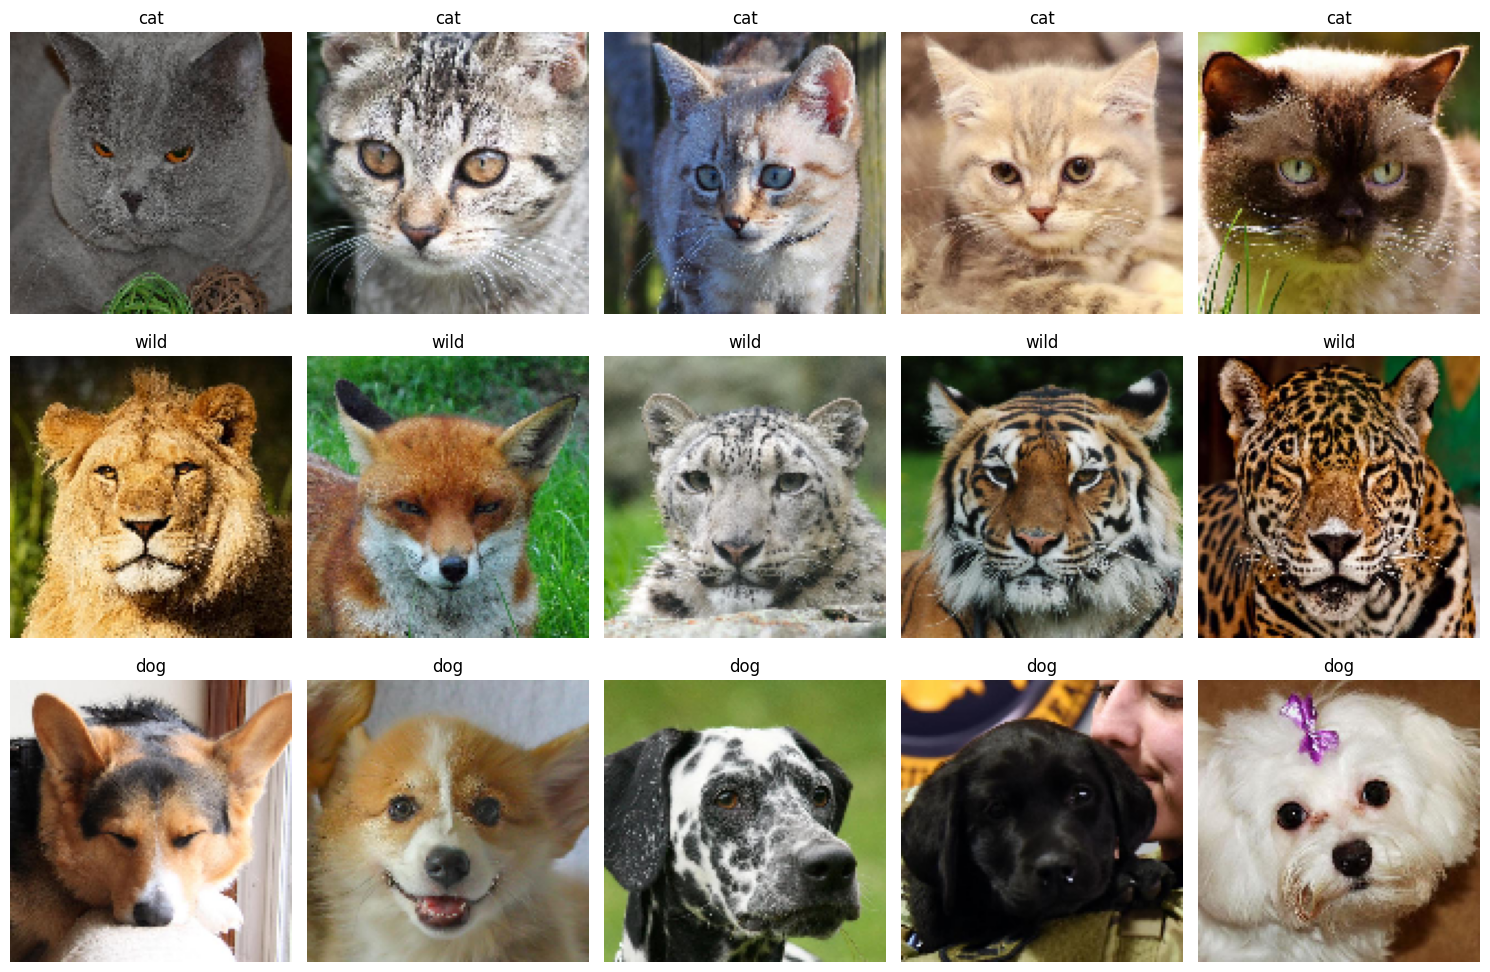

In [18]:
categories = os.listdir(dataset_path)
print("Kategori:", categories)
image_size = (128, 128)
plt.figure(figsize=(15, 10))

for idx, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)

    sample_images = random.sample(images, 5)

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=image_size)

        plt.subplot(len(categories), 5, idx * 5 + i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
categories = os.listdir(dataset_path)

class_counts = {}
total_images = 0

for category in categories:
    category_path = os.path.join(dataset_path, category)
    num_images = len(os.listdir(category_path))
    class_counts[category] = num_images
    total_images += num_images

# Tampilkan hasil
print("Jumlah gambar per kelas:")
for category, count in class_counts.items():
    percentage = (count / total_images) * 100
    print(f"- {category}: {count} gambar ({percentage:.2f}%)")

print(f"\nTotal gambar: {total_images}")


Jumlah gambar per kelas:
- cat: 5153 gambar (35.22%)
- wild: 4738 gambar (32.39%)
- dog: 4739 gambar (32.39%)

Total gambar: 14630


### Plot Distribusi

Text(0, 0.5, 'Jumlah Gambar')

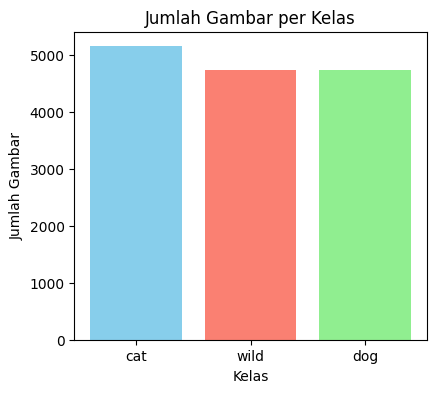

In [20]:
categories = os.listdir(dataset_path)

class_counts = {}
total_images = 0

for category in categories:
    category_path = os.path.join(dataset_path, category)
    num_images = len(os.listdir(category_path))
    class_counts[category] = num_images
    total_images += num_images

labels = list(class_counts.keys())
counts = list(class_counts.values())
percentages = [count / total_images * 100 for count in counts]


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")

Persebaran data sudah cukup seimbang

#### Split Dataset

In [23]:

original_dataset_dir = '/content/drive/MyDrive/UasAIcollab/archive/afhq/dataset'
base_dir = '/content/drive/MyDrive/UasAIcollab/archive/afhq/dataset_split'

for split in ['train', 'val', 'test']:
    for category in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

for category in os.listdir(original_dataset_dir):
    path = os.path.join(original_dataset_dir, category)
    images = os.listdir(path)
    random.shuffle(images)

    total = len(images)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    for file in train_files:
        shutil.copy(os.path.join(path, file), os.path.join(base_dir, 'train', category, file))
    for file in val_files:
        shutil.copy(os.path.join(path, file), os.path.join(base_dir, 'val', category, file))
    for file in test_files:
        shutil.copy(os.path.join(path, file), os.path.join(base_dir, 'test', category, file))


#### Data Generator Setup

In [27]:
base_dir = '/content/drive/MyDrive/UasAIcollab/archive/afhq/dataset_split'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 14056 images belonging to 3 classes.
Found 2785 images belonging to 3 classes.
Found 2789 images belonging to 3 classes.


## Modelling

In [28]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [30]:
checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6
)

callbacks_list = [checkpoint, early_stop, reduce_lr]


In [31]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5927 - loss: 0.8374
Epoch 1: val_accuracy improved from -inf to 0.90736, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 753s 2s/step - accuracy: 0.5930 - loss: 0.8370 - val_accuracy: 0.9074 - val_loss: 0.2485 - learning_rate: 0.0010
Epoch 2/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8683 - loss: 0.3517
Epoch 2: val_accuracy improved from 0.90736 to 0.94219, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.8683 - loss: 0.3516 - val_accuracy: 0.9422 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 3/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9096 - loss: 0.2433
Epoch 3: val_accuracy improved from 0.94219 to 0.96338, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 631s 1s/step - accuracy: 0.9096 - loss: 0.2433 - val_accuracy: 0.9634 - val_loss: 0.1025 - learning_rate: 0.0010
Epoch 4/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9306 - loss: 0.1990
Epoch 4: val_accuracy improved from 0.96338 to 0.96373, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.9305 - loss: 0.1990 - val_accuracy: 0.9637 - val_loss: 0.1089 - learning_rate: 0.0010
Epoch 5/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9356 - loss: 0.1794
Epoch 5: val_accuracy improved from 0.96373 to 0.97163, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.9356 - loss: 0.1794 - val_accuracy: 0.9716 - val_loss: 0.0864 - learning_rate: 0.0010
Epoch 6/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9457 - loss: 0.1567
Epoch 6: val_accuracy did not improve from 0.97163
440/440 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.9457 - loss: 0.1567 - val_accuracy: 0.9555 - val_loss: 0.1387 - learning_rate: 0.0010
Epoch 7/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9487 - loss: 0.1472
Epoch 7: val_accuracy improved from 0.97163 to 0.97846, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.9488 - loss: 0.1472 - val_accuracy: 0.9785 - val_loss: 0.0632 - learning_rate: 0.0010
Epoch 8/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9525 - loss: 0.1323
Epoch 8: val_accuracy did not improve from 0.97846
440/440 ━━━━━━━━━━━━━━━━━━━━ 642s 1s/step - accuracy: 0.9525 - loss: 0.1323 - val_accuracy: 0.9724 - val_loss: 0.0714 - learning_rate: 0.0010
Epoch 9/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9572 - loss: 0.1216
Epoch 9: val_accuracy improved from 0.97846 to 0.98025, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 617s 1s/step - accuracy: 0.9572 - loss: 0.1216 - val_accuracy: 0.9803 - val_loss: 0.0626 - learning_rate: 0.0010
Epoch 10/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9587 - loss: 0.1158
Epoch 10: val_accuracy improved from 0.98025 to 0.98312, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.9587 - loss: 0.1158 - val_accuracy: 0.9831 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 11/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9592 - loss: 0.1160
Epoch 11: val_accuracy improved from 0.98312 to 0.98707, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 725s 2s/step - accuracy: 0.9592 - loss: 0.1160 - val_accuracy: 0.9871 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 12/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9617 - loss: 0.1045
Epoch 12: val_accuracy did not improve from 0.98707
440/440 ━━━━━━━━━━━━━━━━━━━━ 720s 2s/step - accuracy: 0.9617 - loss: 0.1045 - val_accuracy: 0.9756 - val_loss: 0.0707 - learning_rate: 0.0010
Epoch 13/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9640 - loss: 0.1080
Epoch 13: val_accuracy did not improve from 0.98707

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
440/440 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - accuracy: 0.9640 - loss: 0.1080 - val_accuracy: 0.9860 - val_loss: 0.0421 - learning_rate: 0.0010
Epoch 14/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9711 - loss: 0.0813
Epoch 14: val_accuracy improved from 0.98707 to 0.98815, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 640s 1s/step - accuracy: 0.9711 - loss: 0.0812 - val_accuracy: 0.9882 - val_loss: 0.0340 - learning_rate: 2.0000e-04
Epoch 15/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9754 - loss: 0.0628
Epoch 15: val_accuracy did not improve from 0.98815
440/440 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.9754 - loss: 0.0628 - val_accuracy: 0.9853 - val_loss: 0.0471 - learning_rate: 2.0000e-04
Epoch 16/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9781 - loss: 0.0632
Epoch 16: val_accuracy improved from 0.98815 to 0.98995, saving model to best_model.h5


440/440 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.9781 - loss: 0.0632 - val_accuracy: 0.9899 - val_loss: 0.0323 - learning_rate: 2.0000e-04
Epoch 17/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9786 - loss: 0.0645
Epoch 17: val_accuracy did not improve from 0.98995
440/440 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.9786 - loss: 0.0645 - val_accuracy: 0.9892 - val_loss: 0.0403 - learning_rate: 2.0000e-04
Epoch 18/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9802 - loss: 0.0561
Epoch 18: val_accuracy did not improve from 0.98995

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
440/440 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.9802 - loss: 0.0561 - val_accuracy: 0.9896 - val_loss: 0.0368 - learning_rate: 2.0000e-04
Epoch 19/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9813 - loss: 0.0528
Epoch 19: val_accuracy did not improve from 0.98995
440/440 ━━━━━━━━━━━━━━━━━━━━ 678s 2s/step - accuracy: 0.9813 - loss: 

## Evaluasi dan Visualisasi

In [32]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Akurasi Test Set: {test_accuracy * 100:.2f}%")
print(f"Loss Test Set: {test_loss:.4f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 486ms/step - accuracy: 0.9867 - loss: 0.0430
Akurasi Test Set: 98.96%
Loss Test Set: 0.0332


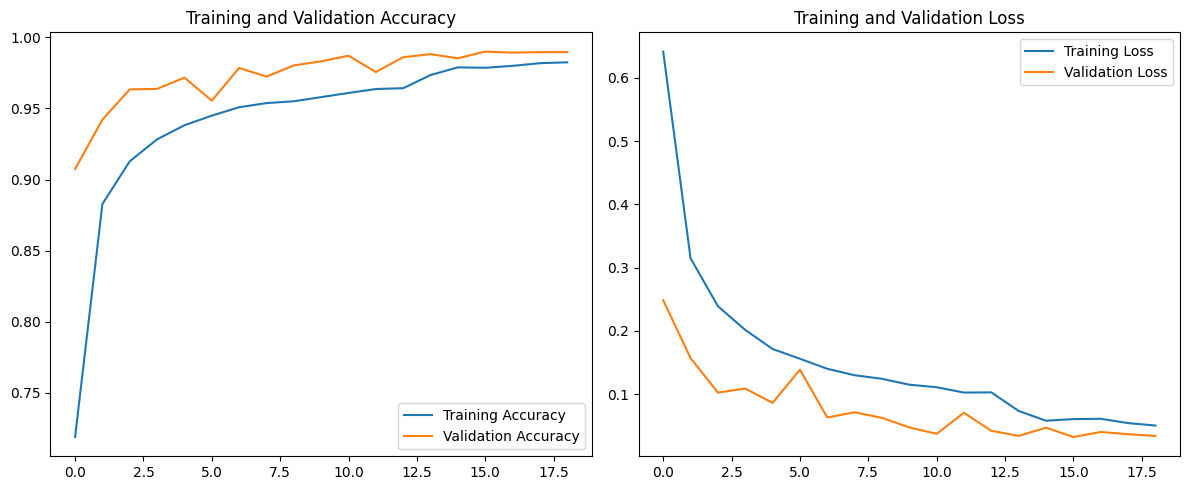

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


## Konversi Model

### Saved Model

In [47]:
model.export('/content/drive/MyDrive/UasAIcollab/saved_model')

Saved artifact at '/content/drive/MyDrive/UasAIcollab/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134874575194256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575205200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575208272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575208080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575207696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575207888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575199824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575207120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575200784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575199440: TensorSpec(shape=(), dtype=tf.resourc

### TF-Lite

In [38]:

drive_path = '/content/drive/MyDrive/UasAIcollab/tflite'

os.makedirs(drive_path, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = os.path.join(drive_path, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

label_map = train_generator.class_indices

labels = sorted(label_map, key=lambda x: label_map[x])

labels_path = os.path.join(drive_path, "labels.txt")
with open(labels_path, "w") as f:
    for label in labels:
        f.write(f"{label}\n")

print("Model dan labels berhasil disimpan di Google Drive!")



Saved artifact at '/tmp/tmpeco12jsm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134874575194256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575205200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575208272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575208080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575207696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575207888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575199824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575207120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575200784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134874575199440: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model dan labels

### TFJS

In [39]:
model.save("model.h5")

In [40]:
# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-26 12:34:44.974685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745670885.058324   79481 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745670885.078648   79481 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [43]:
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/UasAIcollab/tflite/model.tflite')
interpreter.allocate_tensors()

# Dapatkan detail input & output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])


Input shape: [  1 128 128   3]


In [45]:
uploaded_image = None
img_display = Output()
pred_display = Output()

def on_upload_change(change):
    global uploaded_image
    if change['new']:
        file_info = next(iter(change['new'].values()))
        img_data = file_info['content']

        img_array = np.frombuffer(img_data, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        uploaded_image = img_rgb

        img_display.clear_output()
        with img_display:
            plt.imshow(img_rgb)
            plt.axis("off")
            plt.title("Gambar yang Diunggah")
            plt.show()

def on_predict_clicked(b):
    pred_display.clear_output()
    if uploaded_image is None:
        with pred_display:
            print(" Silakan unggah gambar terlebih dahulu.")
        return

    img_resized = cv2.resize(uploaded_image, (128, 128))
    input_data = np.expand_dims(img_resized / 255.0, axis=0).astype(np.float32)

    interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/UasAIcollab/tflite/model.tflite")
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    labels = ['cat', 'dog', 'wild']
    pred_class = np.argmax(output)
    confidence = np.max(output)

    with pred_display:
        print(f" Prediksi: {labels[pred_class]} (Confidence: {confidence:.2f})")

uploader = FileUpload(accept='.jpg,.png,.jpeg', multiple=False)
uploader.observe(on_upload_change, names='value')

predict_button = Button(description="Prediksi Gambar", button_style='success')
predict_button.on_click(on_predict_clicked)

display(VBox([uploader, img_display, predict_button, pred_display]))
